<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Check relation betweeen dynamics and generalization.   Hypothesis to make: generalization can only be understood in level of joint dynamical system, there is a clear link between the two**

**Dynamnics determines generalization , not decoding , same decoding level can have very different dynamics , thus different generalization level.  Only when the dynamics of RNN forms object correspond to real relevant objects for game, the generalization can be good.   For instance , in a varying size game, you extend the size of game from 10 to 30, what will happen?  You can do a kind of dynamical programing , according to which wall you have seen and how many steps you have passed , you decide future action.    This can be achieved robustly by the dynamical system where fix points are correspond to walls**

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import Nets 
from Nets import *

import GLM
from GLM import *

import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

import scipy
from scipy.spatial import distance
from scipy import signal

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

Training from zero seems to be better because it will allow the agent to explore from new

**A coherent result here is threhold kind behaviour of decode vs performance, after decode smaller than 10, the performance rises.  The resutls is showeing that the learning rate vs performance doesn't characterize the threshold kind behaviour of performance change.  It is only after lr = -5, the performance begins to rise , while the learning rate - performance curve creates a fake trends for first few points.  This is not shown by explaination factor calculated by covariance.  **

If look carefully, the slow timescale here is a very long transient,  it will not return to baseline in a very long run of game, that is different from gru, which maintains a baseline.  If the system is a true integrator,  it should not loose the baseline, because there is no concept of return in this case. 

The very slow timescale could make the system harder to reset, except I use a strong input.  So reset upon input and remember is always contradictory.  If I design a task also need to pay attention to fast timescale , this will fail more throughly 

# Real Game Dynamics analysis  
The real game dynamcis shows huge difference performance in speed, stability of results, and also statistics of strategy 

**What is the relation to head direction, this order kept in limit cycle**
**Could we define the order parameter for behaviour and link it to dynamics?**

In [2]:
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint0_0_9'
pregame = PretrainGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 1)
pregame.net.load_state_dict(torch.load(weight))

## Game Performance analysis

## Real game analysis 
**The behaviour is best analyzed by pwd and methods in different sizes of arena, in order to see the strategy is mediated by which loop, the big enviromental feedback(low freq related to size) or small action feedbakd(high freq)**

we take what shows good performance and send it for analysis 


In [3]:
PCAs = []
weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint0_0_9'
for size in [15]:
    pca = PCA(weight = weight, size = size)
    pca.pca()
    PCAs.append(pca.vals[:10]/np.sum(pca.vals))
# plt.plot(pca.vals[:10]/np.sum(pca.vals))

In [83]:
for iters in np.arange(5, 16, 2):
    weight ='weights_fix3/weights3/rnn_1515tanh512_checkpoint39_1_{}'.format(iters)
    pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
    pregame.game.net.load_state_dict(torch.load(weight))
#     pregame.game.grid.grid[ry : ry + 1, rx + 4 : rx + 6] = 0
    grid =  pregame.game.grid.grid.copy()
    pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, grid = grid)
    print (pregame.Performance)

[0.7287387722391061]
[0.8428814597659671]
[0.8836343737188992]
[0.8984871160812647]
[0.9242744566018499]
[0.9235924315831816]


In [18]:
for start in np.arange(2, 17):
    weight ='weights_fix3/weights3/rnn_1515tanh512_checkpoint39_1_9'
    pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
    pregame.game.net.load_state_dict(torch.load(weight))
    grid =  pregame.game.grid.grid.copy()
    pregame.TestAllSizes(size_range = [15], limit_set = 2, test_size = 0, grid = grid, start = (4, start))
    print (pregame.Performance)

[0.08068534655448718]
[0.0908567808109834]
[-0.08344790087785776]
[-0.5178582974137931]
[-0.4767783811240842]
[-0.559845945083014]
[-0.565640122718517]
[-0.556392038665687]
[-0.5499584056712963]
[-0.44969224294722676]
[-0.33732009529423324]
[-0.1282208163863322]
[0.0380483774038462]
[0.21371144165020664]
[0.2916413682526964]


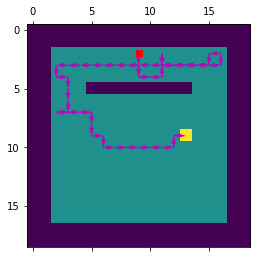

In [16]:
size = 15
PC_traces = []
# torch.manual_seed(1)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (2, 9)

    weight = 'weights_fix4/rnn_1515tanh512_checkpoint39_1_32'
    game = ValueMaxGame(grid_size = (size, size), holes = 50, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
  
    start_w, stop_w = 6, 6
#     Pos1, hidden1, dH1, Action, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    Pos2, hidden2, dH2, Action, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    grid = game.grid.grid.copy()
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'b')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')

#     PC_traces1 = (pca.vect[:10] @ hidden1.T)
#     PC_traces2 = (pca.vect[:10] @ hidden2.T)
#     if reward1 == 1: 
#         PC_traces.extend(PC_traces1[0])
#     if reward2 == 1:
#         PC_traces.extend(PC_traces2[0])
#     if i == 0:
#         plt.figure()
#         for pc in [0, 1, 2]:
#             plt.plot(PC_traces2[pc], label = pc)
#         plt.legend()
#         plt.xlabel('time')
#         plt.ylabel('pca')
#         plt.figure()
#         plt.plot(Action)
# ff, pd = signal.periodogram(np.array(PC_traces), nfft = 100)
# plt.figure()
# plt.plot(ff, pd)
# plt.xlim(0 , 0.1)


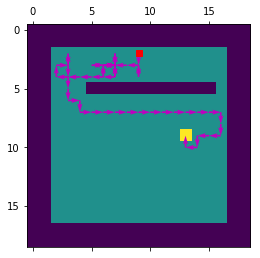

In [88]:
size = 15
PC_traces = []
# torch.manual_seed(1)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (2, 9)

    weight = 'weights_fix4/rnn_1515tanh512_checkpoint39_3_42'
    game = ValueMaxGame(grid_size = (size, size), holes = 50, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
  
    start_w, stop_w = 6, 6
#     Pos1, hidden1, dH1, Action, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    Pos2, hidden2, dH2, State, Action, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    grid = game.grid.grid.copy()
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'b')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

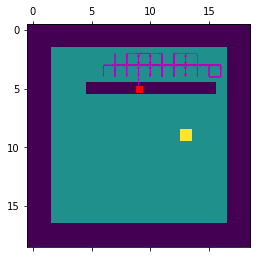

In [41]:
size = 15
PC_traces = []
# torch.manual_seed(1)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (5, 9)

    weight = 'weights_fix4/rnn_1515tanh512_checkpoint0_2_46'
    game = ValueMaxGame(grid_size = (size, size), holes = 50, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    game.net.k_action = 5
    start_w, stop_w = 6, 6
    Pos1, hidden1, dH1, Action, State, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    Pos2, hidden2, dH2, Action, State, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    grid = game.grid.grid.copy()
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'b')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')

#     PC_traces1 = (pca.vect[:10] @ hidden1.T)
#     PC_traces2 = (pca.vect[:10] @ hidden2.T)
#     if reward1 == 1: 
#         PC_traces.extend(PC_traces1[0])
#     if reward2 == 1:
#         PC_traces.extend(PC_traces2[0])
#     if i == 0:
#         plt.figure()
#         for pc in [0, 1, 2]:
#             plt.plot(PC_traces2[pc], label = pc)
#         plt.legend()
#         plt.xlabel('time')
#         plt.ylabel('pca')
#         plt.figure()
#         plt.plot(Action)
# ff, pd = signal.periodogram(np.array(PC_traces), nfft = 100)
# plt.figure()
# plt.plot(ff, pd)
# plt.xlim(0 , 0.1)

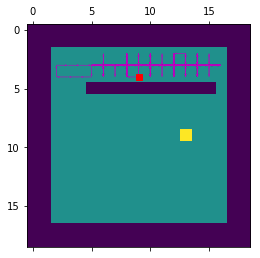

In [102]:
size = 15
PC_traces = []
# torch.manual_seed(1)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (4, 9)

    weight = 'weights_fix4/rnn_1515tanh512_checkpoint0_3_47'
    game = ValueMaxGame(grid_size = (size, size), holes = 50, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    game.net.k_action = 5
    start_w, stop_w = 6, 6
    Pos1, hidden1, dH1, Action, State, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    Pos2, hidden2, dH2, Action, State, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    grid = game.grid.grid.copy()
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'b')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
    # plt.quiver(x3[:-1], y3[:-1], x3[1:]-x3[:-1], y3[1:]-y3[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
    # plt.quiver(x4[:-1], y4[:-1], x4[1:]-x4[:-1], y4[1:]-y4[:-1], scale_units='xy', angles='xy', scale=1, color = 'k')

#     PC_traces1 = (pca.vect[:10] @ hidden1.T)
#     PC_traces2 = (pca.vect[:10] @ hidden2.T)
#     if reward1 == 1: 
#         PC_traces.extend(PC_traces1[0])
#     if reward2 == 1:
#         PC_traces.extend(PC_traces2[0])
#     if i == 0:
#         plt.figure()
#         for pc in [0, 1, 2]:
#             plt.plot(PC_traces2[pc], label = pc)
#         plt.legend()
#         plt.xlabel('time')
#         plt.ylabel('pca')
#         plt.figure()

In [ ]:
size = 15
PC_traces = []
# torch.manual_seed(1)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (4, 9)

    weight = 'weights_fix4/rnn_1515tanh512_checkpoint0_3_47'
    game = ValueMaxGame(grid_size = (size, size), holes = 50, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    game.net.k_action = 5
    start_w, stop_w = 6, 6
    Pos1, hidden1, dH1, Action, State, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    Pos2, hidden2, dH2, Action, State, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w))
    grid = game.grid.grid.copy()
    if i == 0:
        plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])

        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'b')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

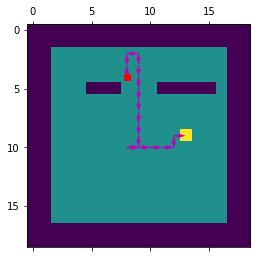

In [113]:
size = 15
PC_traces = []
# torch.manual_seed(2)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (4, 8)
    weight = 'weights_fix4/rnn_1515tanh512_checkpoint39_1_32'
    
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    ry, rx = 5, 5
    game.grid.grid[ry - 1 : ry + 3, rx + 3 : rx + 6] = 0
    grid = game.grid.grid.copy()
   
    start_w, stop_w = 6, 6
    Pos1, hidden1, dH1, Action, State, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w), map_set=grid)
    Pos2, hidden2, dH2, Action, State, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w), map_set=grid)
    grid = game.grid.grid.copy()
    plt.matshow(grid)
    if i == 0:
#         plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])
        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'b')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
#         plt.figure()
#         plt.matshow(grid)
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

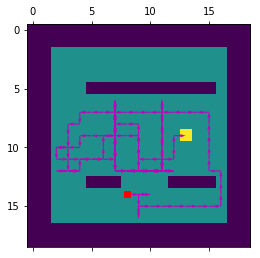

In [200]:
size = 15
PC_traces = []
# torch.manual_seed(2)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (14, 8)
    weight = 'weights_fix4/rnn_1515tanh512_checkpoint39_1_39'
    
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    ry, rx = 5, 5
    game.grid.grid[ry + 8: ry + 9, rx  : rx + 11] = -1
    game.grid.grid[ry + 8: ry + 9, rx+3  : rx + 7] = 0
    grid = game.grid.grid.copy()
   
    start_w, stop_w = 6, 6
    Pos1, hidden1, dH1, Action, State, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w), map_set=grid)
    Pos2, hidden2, dH2, Action, State, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w), map_set=grid)
    grid = game.grid.grid.copy()
    plt.matshow(grid)
    if i == 0:
#         plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])
        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'b')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
#         plt.figure()
#         plt.matshow(grid)
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

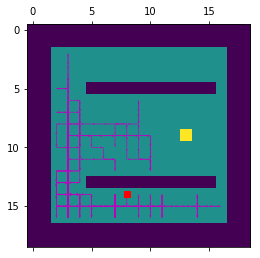

In [160]:
size = 15
PC_traces = []
# torch.manual_seed(2)
hidden = torch.randn(1, 512)
for i in range(1):
    start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
    start = (14, 8)
    weight = 'weights_fix4/rnn_1515tanh512_checkpoint0_3_47'
    
    game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    ry, rx = 5, 5
    game.grid.grid[ry + 8: ry + 9, rx  : rx + 11] = -1
    grid = game.grid.grid.copy()
   
    start_w, stop_w = 6, 6
    Pos1, hidden1, dH1, Action, State, reward1 = trajectory(game, start, reward_control = 0, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w), map_set=grid)
    Pos2, hidden2, dH2, Action, State, reward2 = trajectory(game, start, reward_control = 1, size = size, test = 0, hidden = hidden, wind = (start_w, stop_w), map_set=grid)
    grid = game.grid.grid.copy()
    plt.matshow(grid)
    if i == 0:
#         plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        y2 = np.array([p[0] for p in Pos2])
        x2 = np.array([p[1] for p in Pos2])
        plt.plot(start[1], start[0], 'rs')
#         plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'b')
        x_w, y_w = x1[start_w:stop_w], y1[start_w:stop_w]
        plt.quiver(x_w[:-1], y_w[:-1], x_w[1:]-x_w[:-1], y_w[1:]-y_w[:-1], scale_units='xy', angles='xy', scale=1, color = 'r')
#         plt.figure()
#         plt.matshow(grid)
        plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

In [151]:
for iters in np.arange(5):
    weight = 'weights_fix4/rnn_1515tanh512_checkpoint39_2_31'
    pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
    pregame.game.net.load_state_dict(torch.load(weight))
    pregame.game.grid.grid[ry : ry + 1, rx + 4 : rx + 6] = 0
    grid =  pregame.game.grid.grid.copy()
    pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, grid = grid)
    print (pregame.Performance)

[0.6202037195431302]
[0.6151065944718448]
[0.6675290005997581]
[0.6167103491361735]
[0.5815244996873651]


In [6]:
for iters in np.arange(5):
    weight = 'weights_fix4/rnn_1515tanh512_checkpoint39_1_45'
    pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
    pregame.game.net.load_state_dict(torch.load(weight))
#     pregame.game.grid.grid[ry : ry + 1, rx + 4 : rx + 6] = 0
    grid =  pregame.game.grid.grid.copy()
    pregame.TestAllSizes(size_range = [15], limit_set = 16, test_size = 0, grid = grid)
    print (pregame.Performance)


[0.8235965304730692]
[0.8263532555481614]
[0.8014127789774104]
[0.8335056548859805]
[0.8126778353914886]


[0.726876537642942]
[0.7303056601959653]
[0.7073973849098758]
[0.7620698892996522]
[0.7582346864583486]


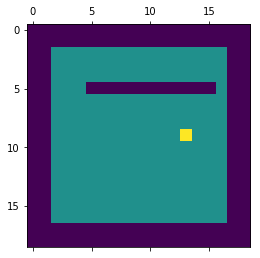

In [7]:
for iters in np.arange(5):
    weight = 'weights_fix/rnn_1515tanh512_checkpoint0_0_49'
    pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
    pregame.game.net.load_state_dict(torch.load(weight))
    grid =  pregame.game.grid.grid.copy()
    pregame.TestAllSizes(size_range = [15], limit_set = 16, test_size = 0, grid = grid)
    print (pregame.Performance)
plt.matshow(grid)

[0.7656592872309593]
[0.6394977902644168]
[0.7127901605669119]
[0.6475551398244805]
[0.7837192670833382]


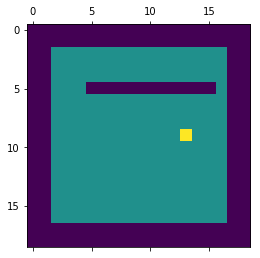

In [8]:
for iters in np.arange(5):
    weight = 'weights_fix4/rnn_1515tanh512_checkpoint0_3_47'
    pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
    pregame.game.net.load_state_dict(torch.load(weight))
    grid =  pregame.game.grid.grid.copy()
    pregame.TestAllSizes(size_range = [15], limit_set = 16, test_size = 0, grid = grid)
    print (pregame.Performance)
plt.matshow(grid)

In [50]:
Performance_block = []
for x in np.arange(2, 17):
    performance= []
    for y in np.arange(4, 5):
        weight = 'weights_fix4/rnn_1515tanh512_checkpoint39_1_32'
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        y = 4
#         pregame.game.grid.grid[ry-1 : ry + 3, rx + 4 : rx + 6] = 0
        grid =  pregame.game.grid.grid.copy()
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, grid = grid, start = (y, x))
#         print (y, x, pregame.Performance)
        performance.append(pregame.Performance)
        print (pregame.Performance)
    Performance_block.append(performance)
np.save('Performance_block', Performance_block)

[0.7642405114974716]
[0.8054199367368772]
[0.776494005730656]
[0.7225167395202452]
[0.5689323906592937]
[0.5217872693291338]
[0.4512738928830744]
[0.5395222715813547]
[0.43392116033295103]
[0.4046997801229946]
[0.4273996474293882]
[0.4623324078321055]
[0.47129513728585437]
[0.4103721822322053]
[0.4871749240062842]


In [48]:
Performance_block = []
for x in np.arange(2, 17):
    performance= []
    for y in np.arange(4, 5):
        weight = 'weights_fix4/rnn_1515tanh512_checkpoint39_1_32'
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        y = 4
        pregame.game.grid.grid[ry-1 : ry + 3, rx + 4 : rx + 6] = 0
        grid =  pregame.game.grid.grid.copy()
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, grid = grid, start = (y, x))
#         print (y, x, pregame.Performance)
        performance.append(pregame.Performance)
        print (pregame.Performance)
    Performance_block.append(performance)
np.save('Performance_short', Performance_block)

[0.768911457804851]
[0.7559868381577259]
[0.7656796389140587]
[0.7123642096186984]
[0.6906044292040643]
[0.589995281928354]
[0.6248485147064528]
[0.646892474507694]
[0.567698328881882]
[0.558384595909089]
[0.599342396994511]
[0.5362445107033824]
[0.49886908874265135]
[0.5717227078442289]
[0.5283624002977028]


In [37]:
np.save('Performance_short.npy', Performance_short)

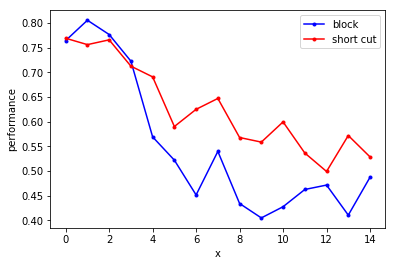

In [51]:
Performance_short = np.load('Performance_short.npy')
Performance_block = np.load('Performance_block.npy')
# Performance_block2 = np.load('Performance_block2.npy')
plt.plot(np.mean(Performance_block, axis = 1), 'b.-', label = 'block')
# plt.plot(np.mean(Performance_block2, axis = 1), 'g.-', label = 'short block')
plt.plot(np.mean(Performance_short, axis = 1), 'r.-', label = 'short cut')
plt.xlabel('x')
plt.ylabel('performance')
plt.legend()

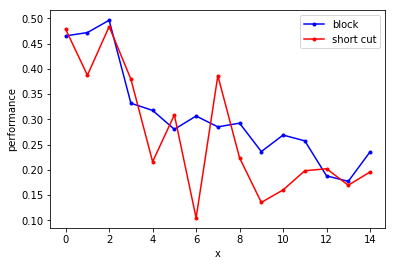

In [93]:
Performance_short = np.load('Performance_a5_short.npy')
Performance_block = np.load('Performance_a5_block.npy')
# Performance_block2 = np.load('Performance_block2.npy')
plt.plot(np.mean(Performance_block, axis = 1), 'b.-', label = 'block')
# plt.plot(np.mean(Performance_block2, axis = 1), 'g.-', label = 'short block')
plt.plot(np.mean(Performance_short, axis = 1), 'r.-', label = 'short cut')
plt.xlabel('x')
plt.ylabel('performance')
plt.legend()

In [91]:
Performance_block = []
for x in np.arange(2, 17):
    performance= []
    for y in np.arange(4, 5):
        weight = 'weights_fix4/rnn_1515tanh512_checkpoint0_3_48'
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        y = 4
#         pregame.game.grid.grid[ry-1 : ry + 3, rx + 4 : rx + 6] = 0
        grid =  pregame.game.grid.grid.copy()
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, grid = grid, start = (y, x))
#         print (y, x, pregame.Performance)
        performance.append(pregame.Performance)
        print (pregame.Performance)
    Performance_block.append(performance)
np.save('Performance_a5_block', Performance_block)

[0.4653242792032555]
[0.47191763298661105]
[0.4963136450161745]
[0.332014858747753]
[0.31775541841729066]
[0.2803761302979868]
[0.30664994399935824]
[0.28523208618938306]
[0.29249944423609153]
[0.23626424137458327]
[0.2689124585139465]
[0.2575047470060651]
[0.18819202812291463]
[0.17731303714298324]
[0.23564478776564363]


In [92]:
Performance_block = []
for x in np.arange(2, 17):
    performance= []
    for y in np.arange(4, 5):
        weight = 'weights_fix4/rnn_1515tanh512_checkpoint0_3_48'
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        y = 4
        pregame.game.grid.grid[ry-1 : ry + 3, rx + 4 : rx + 6] = 0
        grid =  pregame.game.grid.grid.copy()
        pregame.TestAllSizes(size_range = [15], limit_set = 8, test_size = 0, grid = grid, start = (y, x))
#         print (y, x, pregame.Performance)
        performance.append(pregame.Performance)
        print (pregame.Performance)
    Performance_block.append(performance)
np.save('Performance_a5_short', Performance_block)

[0.4784318346170161]
[0.3873550117252258]
[0.4837837334348595]
[0.37975754028959935]
[0.2161823570291649]
[0.30889043717988063]
[0.1048914617872298]
[0.3866157823449461]
[0.22371466125763206]
[0.13559944217335868]
[0.16030178836264072]
[0.19826715555445695]
[0.20228484214678877]
[0.16964487180439977]
[0.1958456983695715]


## GLM 

In [59]:
weight = 'weights_fix4/rnn_1515tanh512_checkpoint39_1_32'
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight)
y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1,\
                                                                                                           Context1)
clf = Lasso(alpha = 1e-3)
cv_scores_all = cross_validate(clf, Features, y, cv = 5, scoring=('r2'), return_train_score = True)
print ('total variance', np.mean(cv_scores_all['train_score']), np.mean(cv_scores_all['test_score']))
importances = []
importances_std = []
for i, feature in enumerate([Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C]):
    clf = Lasso(alpha = 1e-3)
    cv_scores = cross_validate(clf, feature, y, cv = 5, scoring=('r2'), return_train_score = True)
    print ('total variance', np.mean(cv_scores_all['train_score'] -  cv_scores['train_score']), \
           np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances.append(np.mean(cv_scores_all['test_score'] - cv_scores['test_score']))
    importances_std.append(np.std(cv_scores_all['test_score'] - cv_scores['test_score']))

total variance 0.28974023031550156 0.23307010783928503
total variance 0.0195050702971315 0.018335666486177633
total variance 0.02006667418641924 0.009662795306387185
total variance 0.06451546712575826 0.05145692787444463
total variance 0.03173207871152208 0.01677201517588403
total variance 0.02980202726293869 0.03004485852027964
total variance 0.022926422123106548 0.023371167891154853


([<matplotlib.axis.YTick at 0x7ff56c1a2e48>,
 <a list of 7 Text yticklabel objects>)

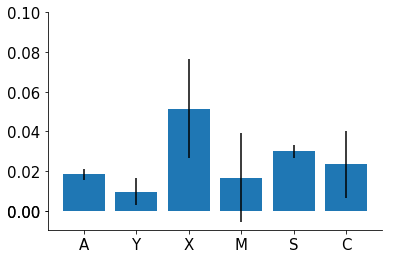

In [61]:
np.save('importance_39', importances)
np.save('importance_39_std', importances_std)
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
imp = np.load('importance_39.npy')
imp_std = np.load('importance_39_std.npy')
plt.bar(np.arange(6), height = imp, yerr = imp_std)
plt.xticks([0, 1, 2, 3, 4, 5], ['A', 'Y', 'X', 'M', 'S', 'C'], size = 15)
plt.yticks([0, 0, 0.02, 0.04, 0.06, 0.08, 0.1], size = 15)

In [22]:
Performance_short = []
for y in np.arange(2, 5):
    for x in np.arange(2, 17):
        weight ='weights_fix3/weights5/rnn_1515tanh512_checkpoint39_0_19'
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        pregame.game.grid.grid[ry-1 : ry + 3, rx + 4 : rx + 6] = 0
        grid =  pregame.game.grid.grid.copy()
        pregame.TestAllSizes(size_range = [15], limit_set = 2, test_size = 0, grid = grid, start = (y, x))
        print (y, x, pregame.Performance)
        Performance_short.append(pregame.Performance)

2 2 [0.6285764853635947]
2 3 [0.7581464477685382]
2 4 [0.7136380546536796]
2 5 [0.6054134678578239]
2 6 [0.5705894853844073]
2 7 [0.5246113830020753]
2 8 [0.617336943655303]
2 9 [0.32331763991516144]
2 10 [0.2893448998917749]
2 11 [0.24146351086609474]
2 12 [0.20689490724343906]
2 13 [0.5195012172733078]
2 14 [0.5241002270299145]
2 15 [0.5748163565617533]
2 16 [0.43445316077152013]
3 2 [0.6437327674053598]
3 3 [0.6075124374996412]
3 4 [0.4417469644394073]
3 5 [0.441236983863937]
3 6 [0.45685751788664203]
3 7 [0.3972603243111056]
3 8 [0.30072732792829776]
3 9 [0.27196812501201323]
3 10 [0.18967255490558294]
3 11 [0.11477413862179486]
3 12 [0.08894742492059066]
3 13 [0.321369353302947]
3 14 [0.23975023028248657]
3 15 [0.36530629201527637]
3 16 [0.10287615740740741]
4 2 [0.740933574888653]
4 3 [0.6294491188707546]
4 4 [0.5305660647945805]
4 5 [0.5479474378014366]
4 6 [0.4240337701989103]
4 7 [0.28430444364610197]
4 8 [0.43715781831016204]
4 9 [0.31624948686371096]
4 10 [0.2705306150767258

Performance_short2 = []
for y in np.arange(2, 5):
    for x in np.arange(2, 17):
        weight ='weights_fix3/weights3/rnn_1515tanh512_checkpoint39_1_29'
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        pregame.game.grid.grid[ry-1 : ry + 3, rx + 4 : rx + 6] = 0
        grid =  pregame.game.grid.grid.copy()
        pregame.TestAllSizes(size_range = [15], limit_set = 2, test_size = 0, grid = grid, start = (y, x))
        print (y, x, pregame.Performance)
        Performance_short2.append(pregame.Performance)

(array([10.,  5.,  6.,  3.,  1.,  3.,  4.,  4.,  7.,  2.]),
 array([-0.08504456, -0.0117448 ,  0.06155496,  0.13485472,  0.20815448,
         0.28145424,  0.354754  ,  0.42805376,  0.50135352,  0.57465328,
         0.64795304]),
 <a list of 10 Patch objects>)

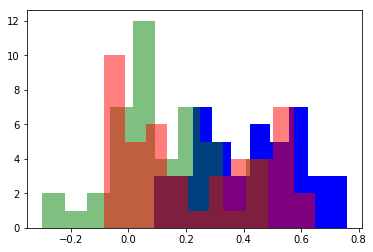

In [24]:
# new trained with bigger shift
plt.hist(np.array(Performance_short).ravel(), color = 'b')
plt.hist(np.array(Performance).ravel(), alpha = 0.5, color = 'g')
plt.hist(np.array(Performance_block).ravel(), alpha = 0.5, color = 'r')

(array([ 3.,  3., 12.,  4.,  7.,  7.,  2.,  1.,  3.,  3.]),
 array([0.00720914, 0.08729314, 0.16737714, 0.24746114, 0.32754513,
        0.40762913, 0.48771313, 0.56779713, 0.64788113, 0.72796513,
        0.80804913]),
 <a list of 10 Patch objects>)

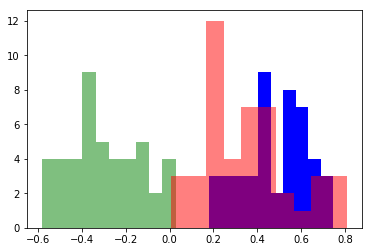

In [41]:
# old trained with small shift
plt.hist(np.array(Performance_short).ravel(), color = 'b')
plt.hist(np.array(Performance).ravel(), alpha = 0.5, color = 'g')
plt.hist(np.array(Performance_block).ravel(), alpha = 0.5, color = 'r')

In [42]:
Performance_block = []
for y in np.arange(2, 5):
    for x in np.arange(2, 17):
        weight ='weights_fix3/weights3/rnn_1515tanh512_checkpoint39_1_15'
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
#         pregame.game.grid.grid[ry-1 : ry + 3, rx + 4 : rx + 6] = 0
        grid =  pregame.game.grid.grid.copy()
        pregame.TestAllSizes(size_range = [15], limit_set = 2, test_size = 0, grid = grid, start = (y, x))
#         print (y, x, pregame.Performance)
        Performance_block.append(pregame.Performance)

In [43]:
Performance = []
for y in np.arange(2, 5):
    for x in np.arange(2, 17):
        weight ='weights_fix3/weights3/rnn_1515tanh512_checkpoint39_1_15'
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        pregame.game.grid.grid[ry-1 : ry + 3, rx + 1 : rx + 11] = 0
        grid =  pregame.game.grid.grid.copy()
        pregame.TestAllSizes(size_range = [15], limit_set = 2, test_size = 0, grid = grid, start = (y, x))
#         print (y, x, pregame.Performance)
        Performance.append(pregame.Performance)

In [44]:
Performance_short = []
for y in np.arange(2, 5):
    for x in np.arange(2, 17):
        weight ='weights_fix3/weights3/rnn_1515tanh512_checkpoint39_1_15'
        pregame = PretrainTest(weight_write = weight, holes = 0, inputs_type = (1, 0))
        pregame.game.net.load_state_dict(torch.load(weight))
        pregame.game.grid.grid[ry-1 : ry + 3, rx + 4 : rx + 6] = 0
        grid =  pregame.game.grid.grid.copy()
        pregame.TestAllSizes(size_range = [15], limit_set = 2, test_size = 0, grid = grid, start = (y, x))
#         print (y, x, pregame.Performance)
        Performance_short.append(pregame.Performance)

(array([ 4., 10.,  9.,  9.,  4.,  2.,  1.,  2.,  3.,  1.]),
 array([-0.06973924,  0.00686071,  0.08346066,  0.16006061,  0.23666056,
         0.31326051,  0.38986046,  0.46646041,  0.54306037,  0.61966032,
         0.69626027]),
 <a list of 10 Patch objects>)

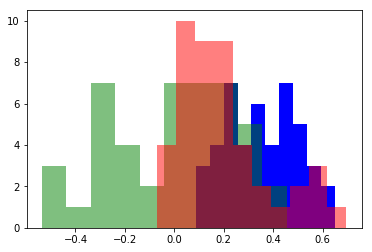

In [45]:
plt.hist(np.array(Performance_short).ravel(), color = 'b')
plt.hist(np.array(Performance).ravel(), alpha = 0.5, color = 'g')
plt.hist(np.array(Performance_block).ravel(), alpha = 0.5, color = 'r')

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**